## Problem Statement

The goal of this analysis is to:

- Explore a custom synthetic HVAC dataset.
- Identify key patterns, trends, and anomalies in the data.
- Apply suitable preprocessing steps, including:
  - Handling missing values,
  - Normalization,
  - Outlier treatment.
- Compute core performance metrics such as:
  - Energy usage,
  - Power consumption.
- Derive additional Key Performance Indicators (KPIs), if applicable, including:
  - HVAC efficiency,
  - Comfort scoring.




## Initial Data Exploration and Insights

<b>Import the Necessary Libraries Here</b>
<hr>

In [1]:
# Import necessary libraries
import pandas as pd              # Data manipulation and analysis
import numpy as np               # Numerical operations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns            # Enhanced visualizations
import os
from statsmodels.tsa.seasonal import seasonal_decompose
# Display settings for cleaner output
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

<b> Data Exploration and Preprocessing </b>
<hr>

In [2]:
# Load the HVAC synthetic dataset
file_name = "hvac_synth.csv"
data_folder = 'data'
data_path = os.path.join(data_folder, file_name)
hvac_data = pd.read_csv(data_path)

# Preview the first few rows
hvac_data.head()

,timestamp,indoor_temp,supply_temp,hvac_control,airflow,power_usage,outdoor_temp,solar_radiation,occupancy,price,temp_error,cooling_demand,heating_demand,indoor_temp_savgol,supply_temp_savgol,outdoor_temp_savgol,temp_error_savgol,hvac_control_sma,airflow_sma,power_usage_sma,solar_radiation_sma,occupancy_sma,price_sma,cooling_demand_sma,heating_demand_sma,hvac_control_ema,airflow_ema,power_usage_ema,solar_radiation_ema,occupancy_ema,price_ema,cooling_demand_ema,heating_demand_ema,indoor_temp_robust,supply_temp_robust,outdoor_temp_robust,temp_error_robust,hvac_control_minmax,airflow_minmax,power_usage_minmax,solar_radiation_minmax,occupancy_minmax,price_minmax,cooling_demand_minmax,heating_demand_minmax
0,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.537145,0.0,0.245344,0.160679,NaN,0.0,NaN,5.815322,-0.184678,-0.084103,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,NaN,NaN,0.0,0.245344,0.160679,0.0,NaN,2.501707,2.501695,-1.397942,2.501707,0.0,0.263284,0.012570,0.0,0.245344,0.453302,0.0,0.040649
1,2020-01-01 00:15:00,NaN,NaN,NaN,0.851765,1416.817844,1.245409,0.0,0.189761,0.163932,NaN,0.0,NaN,5.815322,-0.184678,2.362373,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,0.851765,1416.817844,0.0,0.213582,0.162538,0.0,NaN,2.501707,2.501695,-1.330230,2.501707,0.0,0.263284,0.012570,0.0,0.189761,0.487622,0.0,0.040649
2,2020-01-01 00:30:00,NaN,NaN,NaN,0.881392,1441.962322,3.160134,0.0,0.050169,0.182369,NaN,0.0,NaN,5.815322,-0.184678,3.536728,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,0.868695,1431.186117,0.0,0.142917,0.171114,0.0,NaN,2.501707,2.501695,-1.147177,2.501707,0.0,0.410525,0.104629,0.0,0.050169,0.682176,0.0,0.040649
3,2020-01-01 00:45:00,NaN,NaN,NaN,0.919333,1488.323327,5.058050,0.0,0.215428,0.169229,NaN,0.0,NaN,5.815322,-0.184678,3.720391,-16.184678,1.0,0.901447,1496.661944,0.0,0.236733,0.163987,0.0,16.200316,NaN,0.890593,1455.894100,0.0,0.169435,0.170424,0.0,NaN,2.501707,2.501695,-0.965730,2.501707,0.0,0.599093,0.274367,0.0,0.215428,0.543514,0.0,0.040649
4,2020-01-01 01:00:00,NaN,NaN,NaN,0.866692,1479.400149,1.322290,0.0,0.318407,0.163675,NaN,0.0,NaN,5.815322,-0.184678,2.620375,-16.184678,1.0,0.901447,1496.661944,0.0,0.214750,0.165470,0.0,16.200316,NaN,0.881852,1464.490598,0.0,0.218266,0.168212,0.0,NaN,2.501707,2.501695,-1.322880,2.501707,0.0,0.337469,0.241697,0.0,0.318407,0.484911,0.0,0.040649


In [3]:
print(f"Dataset shape: {hvac_data.shape}")


Dataset shape: (408000, 45)


> As I began exploring the dataset, I quickly noticed its scale: it contains **408,000 data points** spread across **45 features**. This richness offers a great opportunity to uncover meaningful patterns but also calls for careful preprocessing to manage the complexity.


In [4]:
hvac_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408000 entries, 0 to 407999
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   timestamp               408000 non-null  object 
 1   indoor_temp             405616 non-null  float64
 2   supply_temp             405615 non-null  float64
 3   hvac_control            407974 non-null  float64
 4   airflow                 407999 non-null  float64
 5   power_usage             407999 non-null  float64
 6   outdoor_temp            408000 non-null  float64
 7   solar_radiation         408000 non-null  float64
 8   occupancy               408000 non-null  float64
 9   price                   408000 non-null  float64
 10  temp_error              405616 non-null  float64
 11  cooling_demand          408000 non-null  float64
 12  heating_demand          405616 non-null  float64
 13  indoor_temp_savgol      408000 non-null  float64
 14  supply_temp_savgol  

> The `timestamp` column is currently stored as an object type and needs to be converted to a proper `datetime` format for accurate time-based analysis.


### Fix Incorrect Data Types for Accurate Analysis

In [5]:
# Make sure timestamp column is datetime
hvac_data['timestamp'] = pd.to_datetime(hvac_data['timestamp'])

# Determine the temporal coverage of the dataset
min_timestamp = hvac_data['timestamp'].min()
max_timestamp = hvac_data['timestamp'].max()

print(f"The dataset covers a period from {min_timestamp:%Y-%m-%d %H:%M:%S} to {max_timestamp:%Y-%m-%d %H:%M:%S}.")


The dataset covers a period from 2020-01-01 00:00:00 to 2031-08-20 23:45:00.


In [6]:
# Calculate time differences between consecutive rows
time_diffs = hvac_data['timestamp'].diff().dropna()

# View the time differences
print(time_diffs.value_counts())

timestamp
0 days 00:15:00    407999
Name: count, dtype: int64


> The above analysis indicate that the HVAC data is recorded at **15-minute intervals**, spanning from **2020-01-01 00:00:00** to **2031-08-20 23:45:00**. This suggests a consistent and regular sampling frequency throughout the dataset.


### Identify columns with zero variance 

In [7]:
# Identify columns with zero variance (i.e., constant values across all rows)
singleton_columns = hvac_data.columns[hvac_data.nunique() == 1]

# If any such columns exist, display and drop them
if not singleton_columns.empty:
    print(f"Removing the following zero-variance columns: {singleton_columns.tolist()}")
    hvac_data = hvac_data.drop(columns=singleton_columns)
else:
    print("No zero-variance columns found.")
   

Removing the following zero-variance columns: ['hvac_control', 'cooling_demand', 'hvac_control_sma', 'cooling_demand_sma', 'hvac_control_ema', 'cooling_demand_ema', 'hvac_control_minmax', 'cooling_demand_minmax']


> The above analysis indicates that the dataset contains variables with constant values across all rows. Such predictors provide no meaningful information for modeling and have therefore been removed to simplify the dataset.  
>  
> The removed variables are:  
> `hvac_control`, `cooling_demand`, `hvac_control_sma`, `cooling_demand_sma`, `hvac_control_ema`, `cooling_demand_ema`, `hvac_control_minmax`, `cooling_demand_minmax`.


### Analyze correlations between variables

In this dataset, some variables appear to be scaled versions of original features — for example, `power_usage` and `power_usage_minmax`. Identifying such strong correlations can help detect redundancy and simplify the feature space.


In [8]:
# Round the correlation matrix to 2 decimal places to avoid missing near-perfect correlations 
# due to floating-point precision (e.g., 0.999999 ≈ 1.0).
corr_matrix = np.round(hvac_data.corr().abs(), 2)


# Select the upper triangle of the correlation matrix to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find all variable pairs with perfect correlation (correlation = 1.0)
perfect_corr_pairs = [
    (col1, col2) 
    for col1 in upper.columns 
    for col2 in upper.index 
    if upper.loc[col2, col1] == 1.0
]

# Display the pairs
if perfect_corr_pairs:
    print("Perfectly correlated variable pairs:")
    for pair in perfect_corr_pairs:
        print(f"{pair[0]} <--> {pair[1]}")
else:
    print("No perfectly correlated variable pairs found.")


Perfectly correlated variable pairs:
temp_error <--> indoor_temp
heating_demand <--> indoor_temp
heating_demand <--> temp_error
indoor_temp_savgol <--> indoor_temp
indoor_temp_savgol <--> temp_error
indoor_temp_savgol <--> heating_demand
supply_temp_savgol <--> supply_temp
temp_error_savgol <--> indoor_temp
temp_error_savgol <--> temp_error
temp_error_savgol <--> heating_demand
temp_error_savgol <--> indoor_temp_savgol
indoor_temp_robust <--> indoor_temp
indoor_temp_robust <--> temp_error
indoor_temp_robust <--> heating_demand
indoor_temp_robust <--> indoor_temp_savgol
indoor_temp_robust <--> temp_error_savgol
supply_temp_robust <--> supply_temp
supply_temp_robust <--> supply_temp_savgol
outdoor_temp_robust <--> outdoor_temp
temp_error_robust <--> indoor_temp
temp_error_robust <--> temp_error
temp_error_robust <--> heating_demand
temp_error_robust <--> indoor_temp_savgol
temp_error_robust <--> temp_error_savgol
temp_error_robust <--> indoor_temp_robust
airflow_minmax <--> airflow
power

> Correlation analysis reveals that the dataset contains several pairs of perfectly correlated variables (correlation = ±1). This indicates redundancy, as these features convey identical information. To ensure model robustness and avoid multicollinearity—especially in models sensitive to feature independence—it is important to remove one variable from each perfectly correlated pair.

> Additionally, the dataset includes both original variables and their scaled versions (e.g., min-max scaled features). Keeping both may lead to information duplication and bias model learning. We should retain only one version of each feature based on the modeling needs and scaling requirements.


---

## 🚩 Why Are There So Many Perfectly Correlated Variables in This Dataset?

Instead of just removing these variables, **let’s dive deeper to understand the underlying reasons!**

Exploring these correlations can reveal important insights about data preprocessing, feature engineering, or measurement methods used.

---


> Most variables are multiple transformed versions of the same original features, including **Savitzky-Golay (savgol), Simple Moving Average (sma), Exponential Moving Average (ema), Robust filtering, and Min-Max scaling (minmax)**.  
>  
> Let’s categorize these transformations to gain a clearer understanding of the dataset!


In [9]:
# Original variables (raw measurements)
original_variables = [
    'timestamp', 'indoor_temp', 'supply_temp', 'outdoor_temp', 'temp_error', 'airflow', 'power_usage', 'solar_radiation', 'occupancy', 'price', 'heating_demand'
]

# Variables smoothed with Savitzky-Golay filter (smoothing + shape-preserving)
savgol_variables = [
    'indoor_temp_savgol', 'supply_temp_savgol', 'outdoor_temp_savgol', 'temp_error_savgol'
]

# Variables processed with Robust filter (resistant to outliers/spikes)
robust_variables = [
    'indoor_temp_robust', 'supply_temp_robust', 'outdoor_temp_robust', 'temp_error_robust']

# Variables smoothed with Simple Moving Average (SMA)
sma_variables = [
    'airflow_sma', 'power_usage_sma', 'solar_radiation_sma', 'occupancy_sma', 'price_sma', 'heating_demand_sma'
]

# Variables smoothed with Exponential Moving Average (EMA)
ema_variables = [
    'airflow_ema', 'power_usage_ema', 'solar_radiation_ema', 'occupancy_ema', 'price_ema', 'heating_demand_ema'
]

# Variables scaled with Min-Max normalization
minmax_variables = [
    'airflow_minmax', 'power_usage_minmax', 'solar_radiation_minmax', 'occupancy_minmax', 'price_minmax', 'heating_demand_minmax'
]


### Exploring the Unprocessed (Original) Features

In [10]:
# Subset the dataset to include only the original features for EDA
hvac_raw_data = hvac_data[original_variables]

In [11]:
hvac_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408000 entries, 0 to 407999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        408000 non-null  datetime64[ns]
 1   indoor_temp      405616 non-null  float64       
 2   supply_temp      405615 non-null  float64       
 3   outdoor_temp     408000 non-null  float64       
 4   temp_error       405616 non-null  float64       
 5   airflow          407999 non-null  float64       
 6   power_usage      407999 non-null  float64       
 7   solar_radiation  408000 non-null  float64       
 8   occupancy        408000 non-null  float64       
 9   price            408000 non-null  float64       
 10  heating_demand   405616 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 34.2 MB


In [12]:
# finc correlations bewtween original features
# Round the correlation matrix to 2 decimal places to avoid missing near-perfect correlations 
# due to floating-point precision (e.g., 0.999999 ≈ 1.0).
corr_matrix = np.round(hvac_raw_data.corr().abs(), 2)


# Select the upper triangle of the correlation matrix to avoid duplicate pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find all variable pairs with perfect correlation (correlation = 1.0)
perfect_corr_pairs = [
    (col1, col2) 
    for col1 in upper.columns 
    for col2 in upper.index 
    if upper.loc[col2, col1] == 1.0
]

# Display the pairs
if perfect_corr_pairs:
    print("Perfectly correlated variable pairs:")
    for pair in perfect_corr_pairs:
        print(f"{pair[0]} <--> {pair[1]}")
else:
    print("No perfectly correlated variable pairs found.")

Perfectly correlated variable pairs:
temp_error <--> indoor_temp
heating_demand <--> indoor_temp
heating_demand <--> temp_error


> temp_error, heating_demand, and indoor_temp exhibit perfect or near-perfect correlations.
Let’s dig deeper to understand the underlying relationships and dependencies among these variables.

In [13]:
hvac_raw_data[['temp_error', 'heating_demand', 'indoor_temp']].tail(10)

,temp_error,heating_demand,indoor_temp
407990,-16.896892,16.896892,5.103108
407991,-16.951599,16.951599,5.048401
407992,-16.941959,16.941959,5.058041
407993,-16.936464,16.936464,5.063536
407994,-17.000000,17.000000,5.000000
407995,-17.000000,17.000000,5.000000
407996,-16.986922,16.986922,5.013078
407997,-16.956582,16.956582,5.043418
407998,-17.000000,17.000000,5.000000
407999,-17.000000,17.000000,5.000000


>🔍 The heating_demand and temp_error variables appear to be negatively proportional — potentially exact opposites (i.e., one is the negative of the other).
Let’s verify if this relationship holds mathematically.

In [14]:
# Check if 'heating_demand' is exactly the negative of 'temp_error', including NaN alignment
comparison = hvac_data['heating_demand'].equals(-hvac_data['temp_error'])

print(f"Are 'heating_demand' and 'temp_error' perfectly negatively correlated (negatives of each other)?: {comparison}\n")

# If true, drop 'temp_error' to avoid redundancy
if comparison:
    hvac_raw_data = hvac_raw_data.drop(columns=['temp_error'])
    print("'temp_error' column dropped due to perfect negative correlation with 'heating_demand'.")


Are 'heating_demand' and 'temp_error' perfectly negatively correlated (negatives of each other)?: True

'temp_error' column dropped due to perfect negative correlation with 'heating_demand'.


In [15]:
# Drop 'indoor_temp' variable since it is perfectly correlated (correlation = 1) with 'heating_demand'.
# These variables are likely derived from each other, so keeping both is redundant.
hvac_raw_data = hvac_raw_data.drop(columns=['indoor_temp'])

In [16]:
hvac_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408000 entries, 0 to 407999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        408000 non-null  datetime64[ns]
 1   supply_temp      405615 non-null  float64       
 2   outdoor_temp     408000 non-null  float64       
 3   airflow          407999 non-null  float64       
 4   power_usage      407999 non-null  float64       
 5   solar_radiation  408000 non-null  float64       
 6   occupancy        408000 non-null  float64       
 7   price            408000 non-null  float64       
 8   heating_demand   405616 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 28.0 MB


> I'm curious whether the missing (NaN) values for the supply_temp occur consecutively, since this is time series data. If the missing values are confined to a specific time window, we might consider dropping that period altogether.

In [17]:
# Get the index positions (as integers) where any column has NaN
nan_indices = hvac_raw_data[hvac_raw_data['supply_temp'].isnull()].index

# Check if they form a continuous sequence
is_block = all((nan_indices[i] + 1 == nan_indices[i+1]) for i in range(len(nan_indices) - 1))

print("NaN values are in a continuous block:" , is_block)

if is_block:
    hvac_raw_data.dropna(subset=['supply_temp'], inplace=True)


NaN values are in a continuous block: True


In [18]:
hvac_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405615 entries, 2385 to 407999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        405615 non-null  datetime64[ns]
 1   supply_temp      405615 non-null  float64       
 2   outdoor_temp     405615 non-null  float64       
 3   airflow          405615 non-null  float64       
 4   power_usage      405615 non-null  float64       
 5   solar_radiation  405615 non-null  float64       
 6   occupancy        405615 non-null  float64       
 7   price            405615 non-null  float64       
 8   heating_demand   405615 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 30.9 MB


> **Observation:**  
After dropping the null values in the `supply_temp` column, all rows containing null values were removed from the dataset. This suggests that the missing values in `heating_demand`, `airflow`, and `power_usage` likely occurred at the same timestamps as those in `supply_temp`.

> Now, the dataset is free of missing values and ready for exploring relationships between the variables.


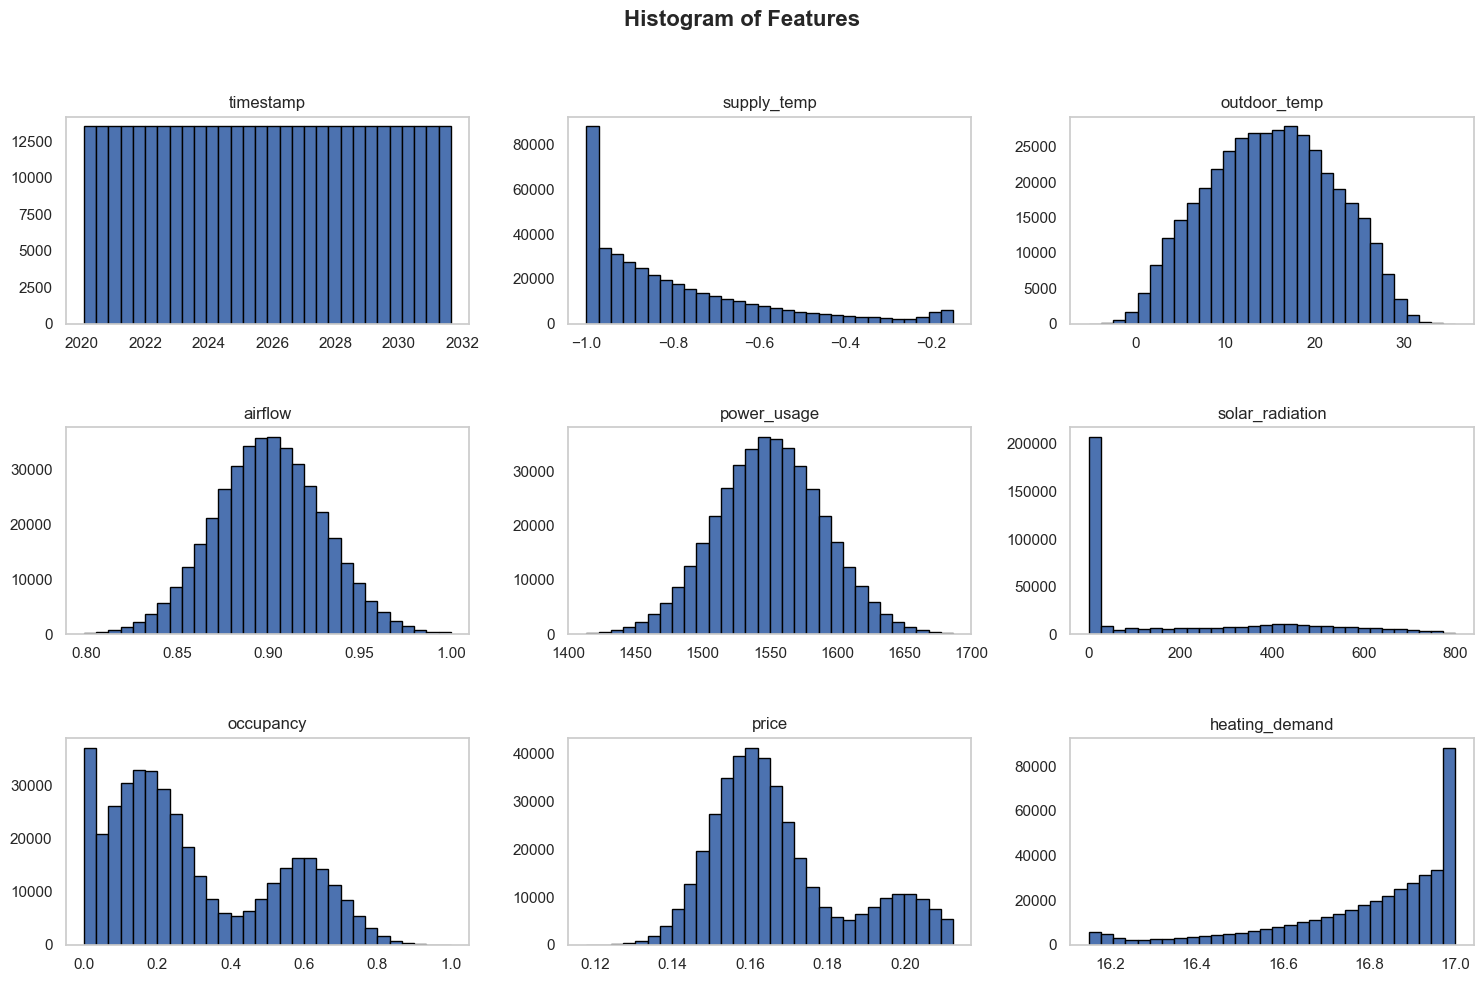

In [19]:
# Plot histograms for all features in hvac_raw_data
hvac_raw_data.hist(bins=30, figsize=(15, 10), grid=False, edgecolor='black')

plt.suptitle("Histogram of Features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
plt.subplots_adjust(hspace=0.5)  # More space between rows
plt.show()


In [20]:
# Set 'timestamp' as the DataFrame index for time-series operations
hvac_raw_data.set_index('timestamp', inplace=True)

<Figure size 1500x800 with 0 Axes>

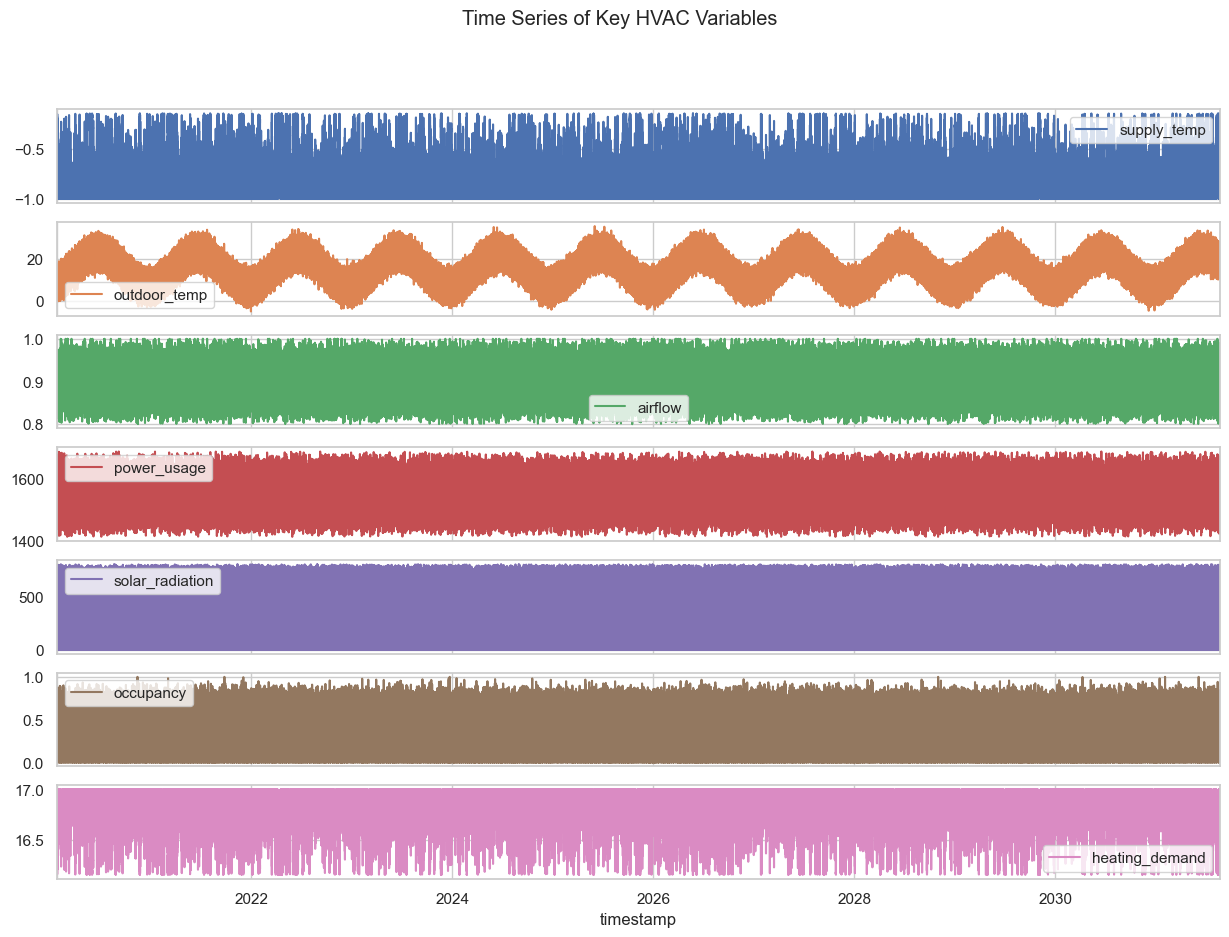

In [21]:
# Time Series Plot of Selected Variables
plt.figure(figsize=(15,8))
hvac_raw_data[['supply_temp', 'outdoor_temp', 'airflow', 'power_usage', 'solar_radiation', 'occupancy','heating_demand', ]].plot(subplots=True, figsize=(15,10))
plt.suptitle("Time Series of Key HVAC Variables")
plt.show()

> **Seasonality in Outdoor Temperature:**  
The outdoor temperature shows clear yearly seasonality — it rises during the first half of the year and falls during the second half. However, this seasonal pattern is not immediately visible in other variables such as `heating_demand`. To better understand potential seasonal effects in those variables, we may need to analyze the data at a different time granularity (e.g., monthly or weekly averages).


In [31]:
#Resample to Daily Means to Check Seasonality
daily_data = hvac_raw_data.resample('D').mean()


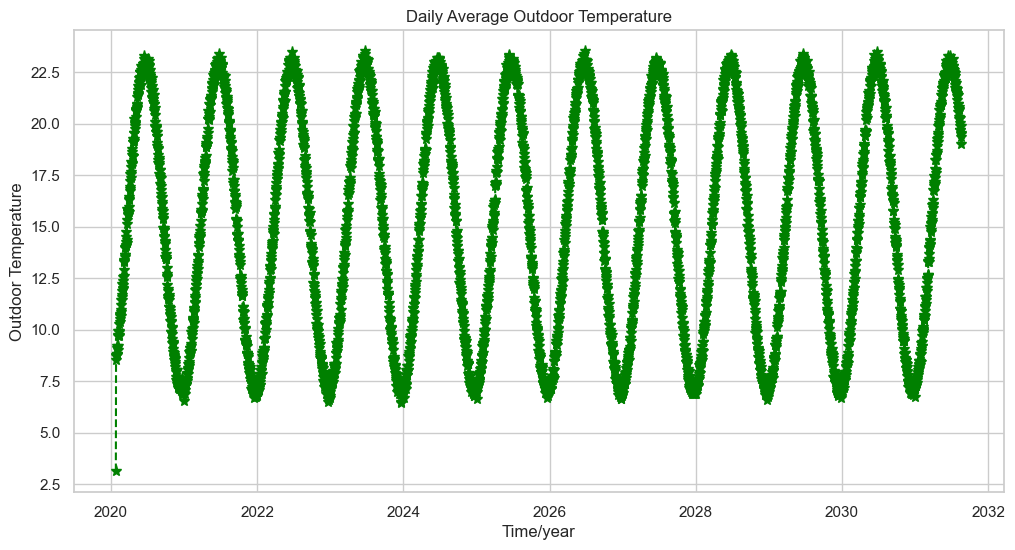

In [32]:
plt.figure(figsize=(12,6))
plt.plot(daily_data['outdoor_temp'], marker='*', color='green', linestyle='--', markersize=8 )
plt.title("Daily Average Outdoor Temperature")
plt.xlabel("Time/year")
plt.ylabel("Outdoor Temperature")
plt.show()

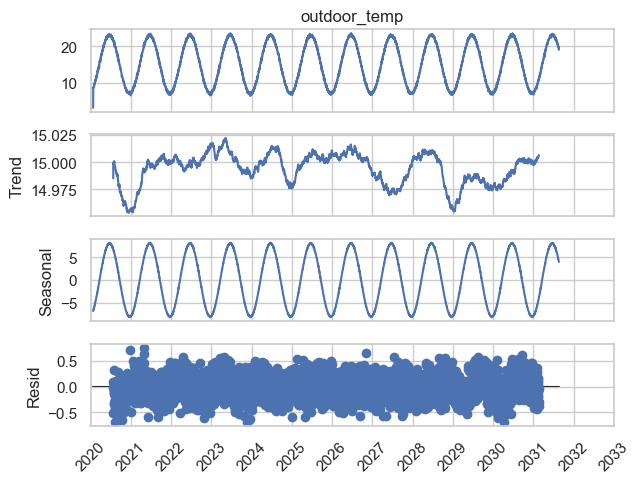

In [27]:
# Perform a time series decomposition into the trend, seasonality, and residuals¶
decomposition = seasonal_decompose(daily_data['outdoor_temp'], model='additive', period=365)
decomposition.plot()
years = pd.date_range(start='2020', end='2033', freq='YS')
plt.xticks(ticks=years, labels=[str(year.year) for year in years], rotation=45)
plt.show()



#### Comment
### Trend Component (14.975 to 15.025)
- This narrow range suggests **little to no long-term upward or downward trend** (yearly) in the average outdoor temperature.
- It's effectively flat, indicating that the **yearly average temperature remains stable** over time.

### Seasonal Component (-5 to +5, sinusoidal shape)
- This indicates a **strong yearly seasonality** — temperature rises and falls in a predictable, wave-like pattern.
- The sinusoidal shape reflects the **cyclical nature of seasons** (e.g., warmer in summer, colder in winter).
- The amplitude (±5) shows the **degree of fluctuation** around the average temperature across the year. The outdoor temperature is typically 5 degrees higher than average during the warmest part of the year. It is also 5 degrees lower than average during the coldest part of the year.

### Residual Component (-0.5 to +0.5)
- The residuals capture the **random noise** not explained by the trend or seasonal components.
- The relatively narrow range (±0.5) suggests that the model has captured most of the structure in the data.
- These small fluctuations indicate **low variability** beyond the identified trend and seasonality — a sign of a **good decomposition fit**.




### Explore Power Usage Seasonality  
Given the strong yearly seasonality observed in outdoor temperature, I will investigate whether power usage exhibits a similar seasonal pattern.

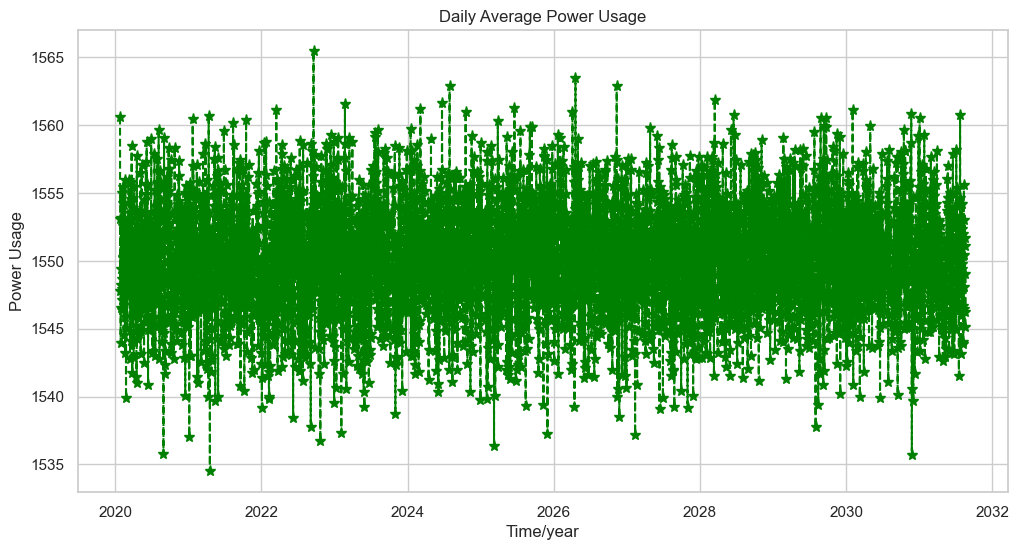

In [35]:
plt.figure(figsize=(12,6))
plt.plot(daily_data['power_usage'], marker='*', color='green', linestyle='--', markersize=8)
plt.title("Daily Average Power Usage")
plt.xlabel("Time/year")
plt.ylabel("Power Usage")
plt.show()

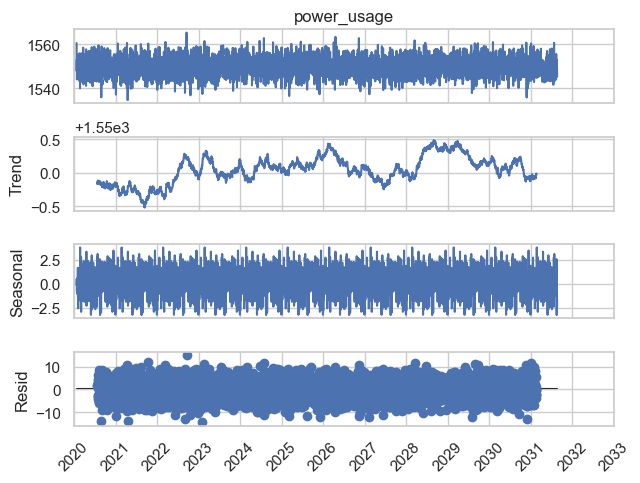

In [36]:
# Perform a time series decomposition into the trend, seasonality, and residuals¶
decomposition = seasonal_decompose(daily_data['power_usage'], model='additive', period=365)
decomposition.plot()
years = pd.date_range(start='2020', end='2033', freq='YS')
plt.xticks(ticks=years, labels=[str(year.year) for year in years], rotation=45)
plt.show()

#### Comment
### Trend Component (Approximately 1549.5 to 1550.5)  
The trend values vary narrowly between approximately 1549.5 and 1550.5, indicating a stable long-term pattern with no significant upward or downward movement over the period from 2020 to 2033.

### Seasonal Component (-2.5 to 2.5)  
Power usage changes a little throughout the year, going up or down by about 2.5 units. This means there is a small seasonal effect (like slightly higher use in winter or summer), but overall, the power demand stays fairly steady.

### Residual Component (-10 to 10)  
The residuals are the random ups and downs that the trend and seasonal parts don’t explain. Since these vary more (between -10 and 10), it means other factors also affect power usage, such as:  
- Daily or weekly usage patterns not captured by yearly seasonality  
- Changes in occupancy or equipment use  
- Measurement errors or unusual events
